In [1]:
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap 
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

# Import datasets

In [2]:
csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL1", "TSR_ALL1_X_TRAIN.csv")
X_train = pd.read_csv(csv_path)

csv_path = os.path.join("..", "..", "data", "LINKED_DATA", "TSR_ALL", "TSR_ALL1", "TSR_ALL1_y_TRAIN.csv")
y_train = pd.read_csv(csv_path)

# XGBC

In [3]:
pkl_path = os.path.join("..", "..", "model", "model_pickle", "MICE5", "TSR_ALL1_XGBC_TUNED.pkl")
XGBC_TUNED = joblib.load(pkl_path)

pkl_path = os.path.join("..", "..", "model", "model_pickle", "MICE5", "TSR_ALL1_XGBC_CALIBRATED.pkl")
XGBC_CALIBRATED = joblib.load(pkl_path)

In [4]:
xgbc_fi = XGBC_CALIBRATED.base_estimator._final_estimator.feature_importances_
xgbc_fi_df = pd.DataFrame(xgbc_fi)
xgbc_fi_df.index = X_train.columns
xgbc_fi_df.columns = (["Value"])
xgbc_fi_plot = xgbc_fi_df.reset_index(drop=False)
xgbc_fi_plot.columns = (["Feature", "Value"])
xgbc_fi_plot = xgbc_fi_plot.sort_values(["Value"], ascending=True)

In [5]:
xgbc_fi_plot_noZERO = xgbc_fi_plot[~xgbc_fi_plot.Value.isin([0])]
xgbc_fi_plot_noZERO_mean = xgbc_fi_plot_noZERO.Value.mean()
xgbc_fi_plot_noZERO_std = xgbc_fi_plot_noZERO.Value.std()
sigma_n = len(xgbc_fi_plot_noZERO[xgbc_fi_plot_noZERO.Value > xgbc_fi_plot_noZERO_mean + xgbc_fi_plot_noZERO_std])
sigma_n

6

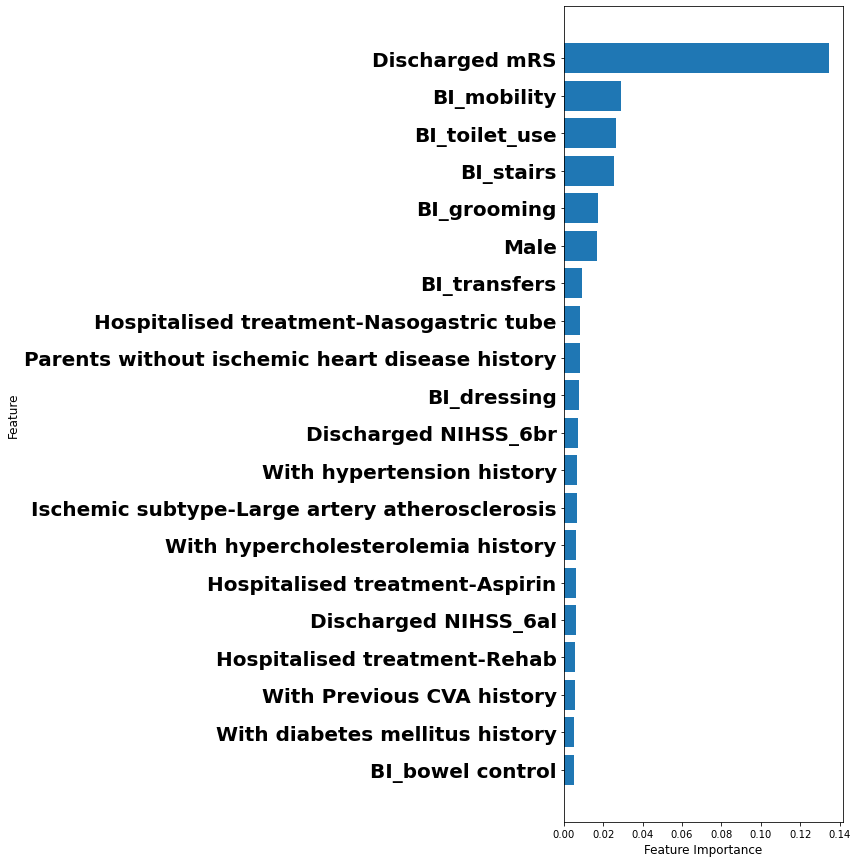

In [6]:
plt.figure(figsize=(5, 15))
plt.barh(xgbc_fi_plot.tail(20).Feature, xgbc_fi_plot.tail(20).Value)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.yticks(fontsize=20)
plt.yticks(weight = 'bold')
#plt.savefig('PLOT/TSR_ALL1/XGBC_F.png', dpi=300, bbox_inches="tight")
plt.show()

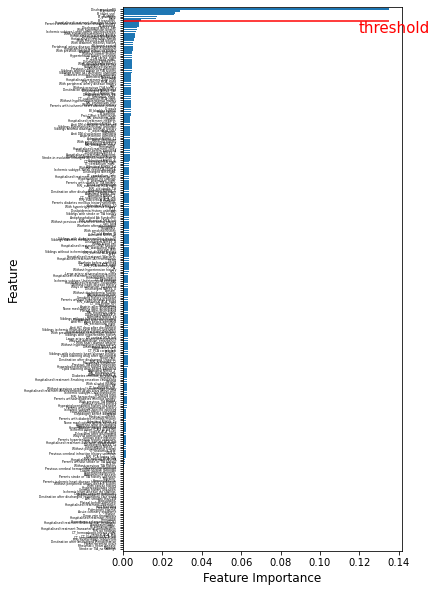

In [7]:
plt.figure(figsize=(5, 10))
plt.barh(xgbc_fi_plot.Feature, xgbc_fi_plot.Value)
plt.hlines(283.5,0,max(xgbc_fi_plot.Value),color="red")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.yticks(fontsize=3)
plt.ylim((-1,291))
plt.text(max(xgbc_fi_plot.Value)-0.015,277, "threshold", fontsize=15, color="red")
#plt.savefig('PLOT/TSR_ALL1/XGBC.png', dpi=300, bbox_inches="tight")
plt.show()

In [8]:
xgbc_fi_plot_20 = xgbc_fi_plot.sort_values(["Value"], ascending=False).Feature.head(20)
X_train_selected = X_train[xgbc_fi_plot_20]

XGBC_TUNED_20 = XGBC_CALIBRATED.base_estimator.fit(X_train_selected, np.ravel(y_train))
cccv_selected = CalibratedClassifierCV(base_estimator=XGBC_TUNED_20, cv=5)
XGBC_CALIBRATED_20 = cccv_selected.fit(X_train_selected, np.ravel(y_train))

xgbc_fi_s = XGBC_CALIBRATED_20.base_estimator._final_estimator.feature_importances_
xgbc_fi_s_df = pd.DataFrame(xgbc_fi_s)
xgbc_fi_s_df.index = X_train_selected.columns
xgbc_fi_s_df.columns = (["Value"])
xgbc_fi_s_df = xgbc_fi_s_df.sort_values(["Value"], ascending=False)

100%|===================| 27545/27553 [02:41<00:00]        

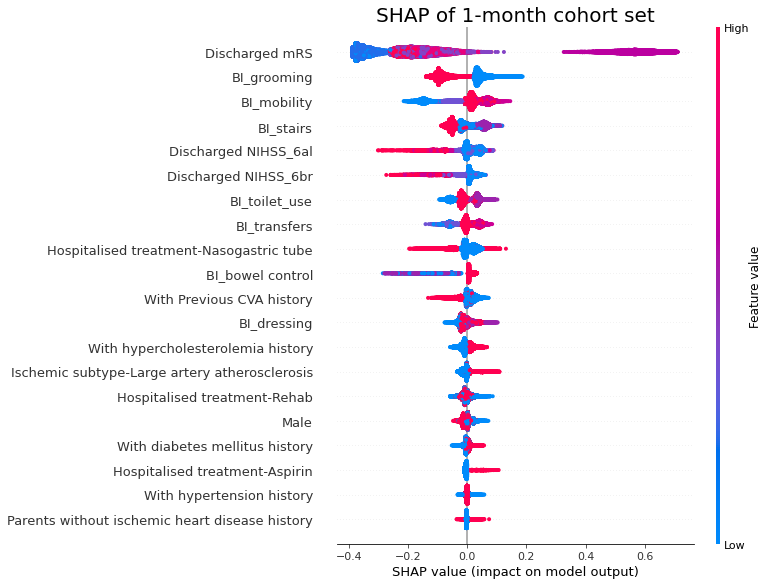

In [9]:
xgbc1_shap_values = shap.TreeExplainer(XGBC_CALIBRATED_20.base_estimator._final_estimator, X_train_selected).shap_values(X_train_selected)
plt.title('SHAP of 1-month cohort set', fontsize=20)
shap.summary_plot(xgbc1_shap_values, X_train_selected, max_display=30,show=False)
plt.savefig('PLOT/TSR_ALL1/SHAP_1_XGBC.png', dpi=300, bbox_inches="tight")